In [28]:
!pip3 install keras-visualizer
import sys, os, random, IPython, warnings, music21
from music21 import *
from IPython.display import Image, Audio
from collections import Counter
warnings.filterwarnings("ignore")
from keras_visualizer import visualizer 
warnings.simplefilter("ignore")
from music21 import note
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
np.random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cwd = os.getcwd()
filepath = cwd + "/drive/MyDrive/Halsey-music"

all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        print(i)
        tr = filepath+"/"+i
        midi = converter.parse(tr)
        all_midis.append(midi)

Colors.mid
Gasoline.mid
Closer.mid
Sorry.mid
So_Good.mid
Him_I.mid
Balenciaga.mid
Tradition.mid
Graveyard.mid
You_Should_Be_Sad.mid
Nightmare.mid
New_Americana.mid
Drive.mid
1121.mid
I_Hate_Everybody.mid
11_Minutes.mid
Is_There_Somewhere.mid
3am.mid
Without_Me.mid
More.mid
Hold_Me_Down.mid
Roman_Holiday.mid


In [12]:
def extract_notes(file):
    notes = []
    durations = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                    durations.append(element.duration.quarterLength)
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
                    durations.append(element.duration.quarterLength)

    return notes, durations

Corpus_notes, Corpus_durations = extract_notes(all_midis)
print(Corpus_durations)

[Fraction(2, 3), 0.75, 0.75, 0.5, 1.25, 1.25, 0.5, 1.0, 1.0, 0.25, 0.25, 0.25, Fraction(29, 12), Fraction(20, 3), 1.25, Fraction(2, 3), 1.75, 1.5, 0.5, 1.25, 2.0, Fraction(1, 3), Fraction(2, 3), Fraction(2, 3), Fraction(1, 3), 0.25, 0.5, Fraction(5, 12), 0.25, Fraction(4, 3), 0.75, 0.5, Fraction(2, 3), Fraction(1, 3), Fraction(2, 3), 1.0, 0.5, 0.5, 0.5, 1.25, 2.75, 2.5, 0.75, 1.25, Fraction(10, 3), Fraction(2, 3), 0.5, Fraction(2, 3), 1.5, 0.5, 1.5, Fraction(1, 3), Fraction(1, 3), Fraction(1, 3), 1.0, Fraction(7, 6), Fraction(1, 6), Fraction(25, 6), Fraction(1, 6), 1.0, Fraction(4, 3), 1.0, 1.0, 1.75, 1.25, Fraction(1, 3), 0.25, 0.5, Fraction(1, 3), Fraction(2, 3), 3.0, Fraction(2, 3), 1.25, 0.5, 0.25, 0.25, 1.0, 1.0, 1.0, 0.5, Fraction(1, 3), 0.5, 1.0, 0.75, 0.5, 2.25, 2.75, 0.25, 4.75, 0.5, 1.25, Fraction(8, 3), 1.5, 0.75, 1.0, Fraction(1, 3), 0.5, 1.25, Fraction(1, 3), 1.0, 0.25, 0.75, Fraction(2, 3), 1.0, 0.5, 0.5, Fraction(2, 3), 0.75, 0.5, 0.75, Fraction(1, 3), 1.25, Fraction(2, 

In [13]:
symb_notes = sorted(list(set(Corpus_notes))) 
symb_durations = sorted(list(set(Corpus_durations))) 

L_notes = len(Corpus_notes) 
L_durations = len(Corpus_durations)  
L_symb_notes = len(symb_notes) 
L_symb_durations = len(symb_durations) 

mapping_notes = dict((c, i) for i, c in enumerate(symb_notes))  
mapping_durations = dict((c, i) for i, c in enumerate(symb_durations))  
reverse_mapping_notes = dict((i, c) for i, c in enumerate(symb_notes)) 
reverse_mapping_durations = dict((i, c) for i, c in enumerate(symb_durations))

print("Total number of notes: ", L_notes)
print("Number of unique notes: ", L_symb_notes)
print("Total number of durations: ", L_durations)
print("Number of unique durations: ", L_symb_durations)

Total number of notes:  25515
Number of unique notes:  259
Total number of durations:  25515
Number of unique durations:  75


In [14]:
length = 40
note_features = []
duration_features = []
note_targets = []
duration_targets = []
for i in range(0, L_notes - length, 1):
    note_feature = Corpus_notes[i:i + length]
    duration_feature = Corpus_durations[i:i + length]
    target_note = Corpus_notes[i + length]
    target_duration = Corpus_durations[i + length]
    note_features.append([mapping_notes[j] for j in note_feature])
    duration_features.append([mapping_durations[k] for k in duration_feature])
    note_targets.append(mapping_notes[target_note])
    duration_targets.append(mapping_durations[target_duration])

L_datapoints = len(note_targets)
print("Total number of sequences in the corpus: ", L_datapoints)

Total number of sequences in the corpus:  25475


In [15]:
note_features = (np.reshape(note_features, (L_datapoints, length, 1))) / float(L_symb_notes)
duration_features = (np.reshape(duration_features, (L_datapoints, length, 1))) / float(L_symb_durations)
note_targets = tensorflow.keras.utils.to_categorical(note_targets)
duration_targets = tensorflow.keras.utils.to_categorical(duration_targets)

In [16]:

X_note_train, X_note_test, X_duration_train, X_duration_test, y_target_note_train, y_target_note_test, y_target_duration_train, y_target_duration_test = train_test_split(
    note_features, duration_features, note_targets, duration_targets, test_size=0.2, random_state=41
)


In [37]:
note_input = Input(shape=(X_note_train.shape[1], X_note_train.shape[2]))
duration_input = Input(shape=(X_duration_train.shape[1], X_duration_train.shape[2]))

note_branch = LSTM(256, return_sequences=True)(note_input)
note_branch = Dropout(0.1)(note_branch)
note_branch = LSTM(128)(note_branch)

duration_branch = LSTM(256, return_sequences=True)(duration_input)
duration_branch = Dropout(0.1)(duration_branch)
duration_branch = LSTM(128)(duration_branch)

merged = Concatenate()([note_branch, duration_branch])
merged = Dense(128)(merged)
merged = Dropout(0.1)(merged)

output_note = Dense( y_target_note_train.shape[1], activation='softmax')(merged)
output_duration = Dense( y_target_duration_train.shape[1], activation='softmax')(merged)

model = Model(inputs=[note_input, duration_input], outputs=[output_note, output_duration])

opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              optimizer=opt,
              metrics=["accuracy"]),

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 40, 1)]      0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 40, 1)]      0           []                               
                                                                                                  
 lstm_20 (LSTM)                 (None, 40, 256)      264192      ['input_11[0][0]']               
                                                                                                  
 lstm_22 (LSTM)                 (None, 40, 256)      264192      ['input_12[0][0]']               
                                                                                            

In [38]:
history = model.fit([X_note_train, X_duration_train], [y_target_note_train, y_target_duration_train], batch_size=128, epochs=180)

Epoch 1/180
160/160 [==============================] - 11s 21ms/step - loss: 7.4745 - dense_16_loss: 4.6376 - dense_17_loss: 2.8369 - dense_16_accuracy: 0.0403 - dense_17_accuracy: 0.1547
Epoch 2/180
160/160 [==============================] - 4s 22ms/step - loss: 7.3487 - dense_16_loss: 4.5826 - dense_17_loss: 2.7661 - dense_16_accuracy: 0.0398 - dense_17_accuracy: 0.1596
Epoch 3/180
160/160 [==============================] - 3s 21ms/step - loss: 7.3023 - dense_16_loss: 4.5533 - dense_17_loss: 2.7490 - dense_16_accuracy: 0.0430 - dense_17_accuracy: 0.1675
Epoch 4/180
160/160 [==============================] - 3s 20ms/step - loss: 7.2734 - dense_16_loss: 4.5327 - dense_17_loss: 2.7407 - dense_16_accuracy: 0.0417 - dense_17_accuracy: 0.1683
Epoch 5/180
160/160 [==============================] - 3s 21ms/step - loss: 7.2396 - dense_16_loss: 4.5086 - dense_17_loss: 2.7311 - dense_16_accuracy: 0.0417 - dense_17_accuracy: 0.1688
Epoch 6/180
160/160 [==============================] - 4s 25ms/s

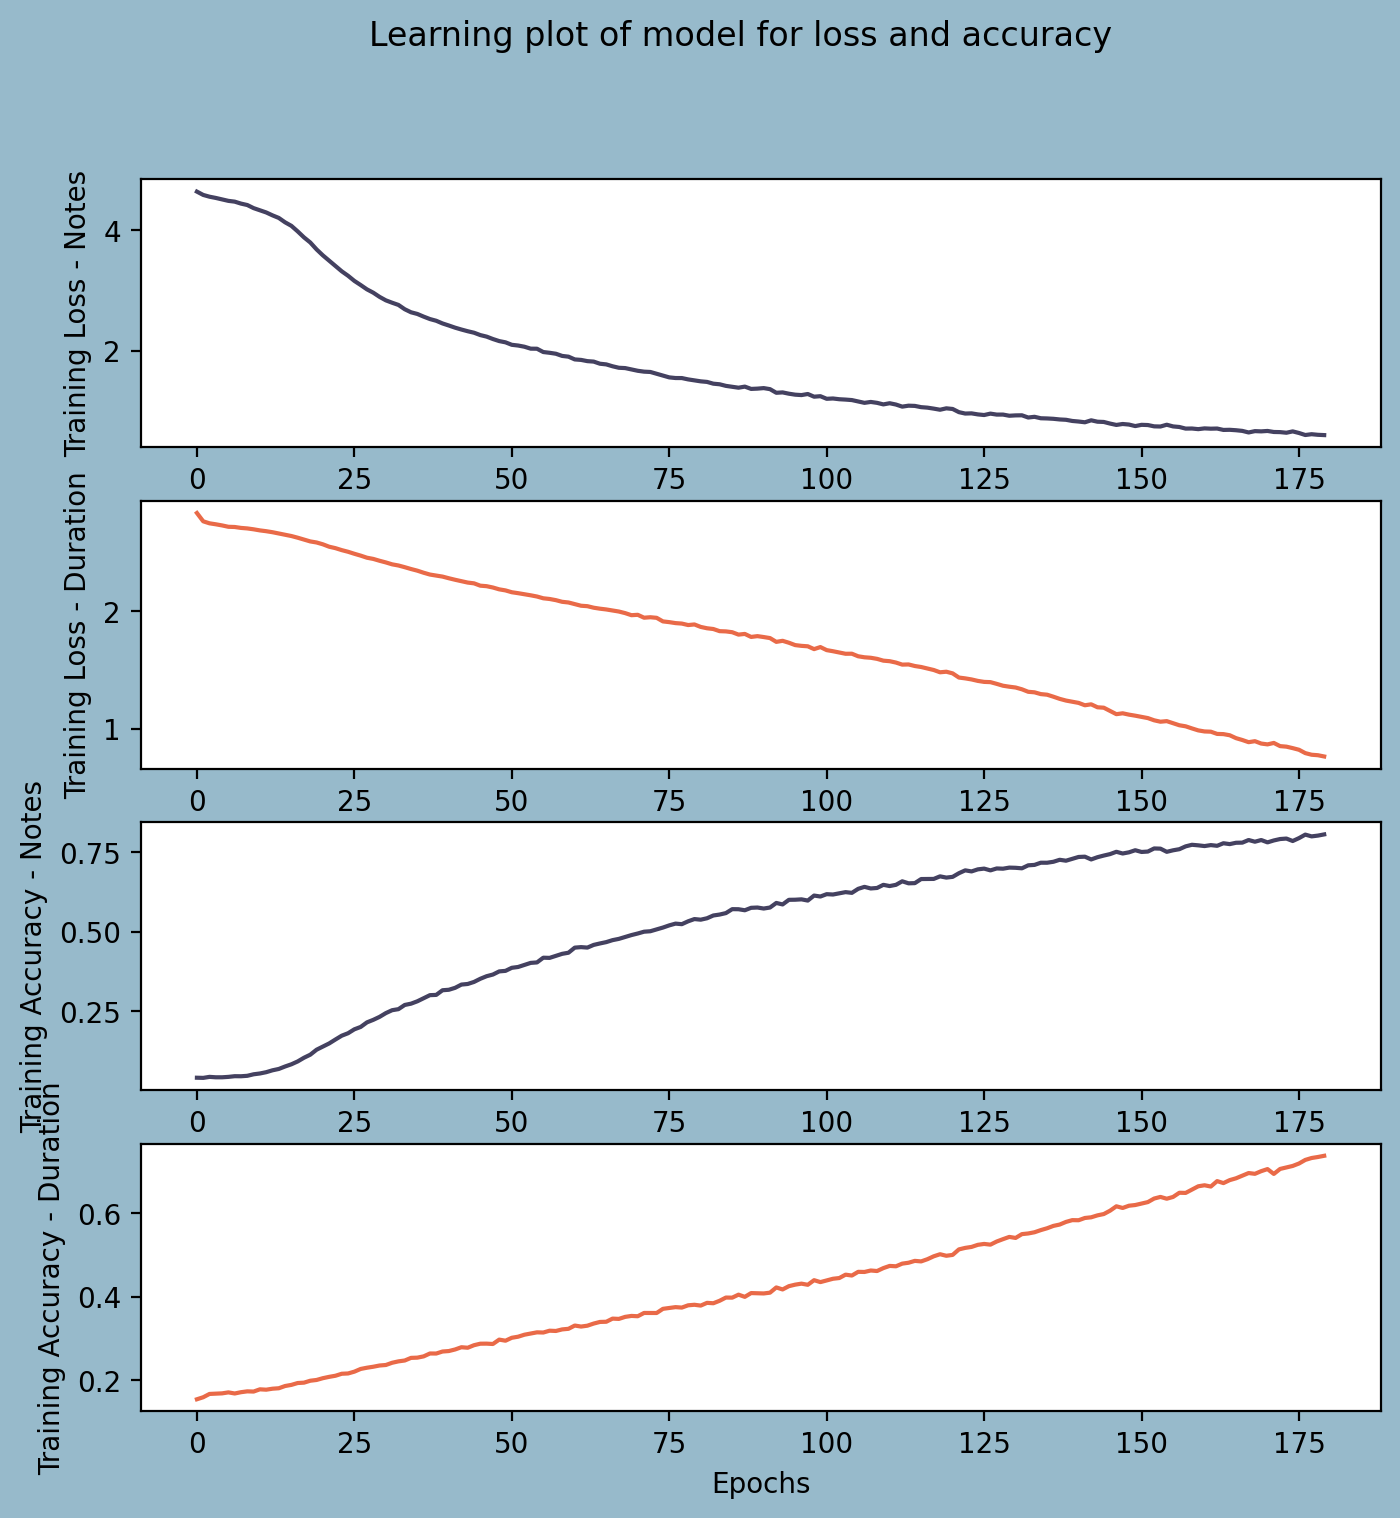

In [47]:
history_df = pd.DataFrame(history.history)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8), facecolor="#97BACB")
fig.suptitle("Learning plot of model for loss and accuracy")

# Plot Loss
sns.lineplot(data=history_df["dense_16_loss"], color="#444160", ax=ax1)
ax1.set_ylabel("Training Loss - Notes")
ax1.set_xlabel("Epochs")

# Plot Accuracy
sns.lineplot(data=history_df["dense_17_loss"], color="#E96A48", ax=ax2)
ax2.set_ylabel("Training Loss - Duration")
ax2.set_xlabel("Epochs")

# Plot Loss
sns.lineplot(data=history_df["dense_16_accuracy"], color="#444160", ax=ax3)
ax3.set_ylabel("Training Accuracy - Notes")
ax3.set_xlabel("Epochs")

# Plot Accuracy
sns.lineplot(data=history_df["dense_17_accuracy"], color="#E96A48", ax=ax4)
ax4.set_ylabel("Training Accuracy - Duration")
ax4.set_xlabel("Epochs")

plt.show()

In [39]:
def chords_n_notes(Snippet_notes, Snippet_durations):
    Melody = []
    offset = 0
    for note_val, duration_val in zip(Snippet_notes, Snippet_durations):
        # in case it is a chord
        if ("." in note_val or note_val.isdigit()):
            chord_notes = note_val.split(".")
            notes = [] 
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                note_snip.duration = duration.Duration(duration_val)
                note_snip.duration.quarterLength = duration_val
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            Melody.append(chord_snip)
        # in case it is a note
        else: 
            note_snip = note.Note(note_val)
            note_snip.offset = offset
            note_snip.duration.quarterLength = duration_val
            Melody.append(note_snip)

        offset += duration_val

    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

def Melody_Generator(Note_Count):
    seed_notes = X_note_test[np.random.randint(0, len(X_note_test) - 1)]
    seed_durations = X_duration_test[np.random.randint(0, len(X_duration_test) - 1)]
    Music = []
    Notes_Generated = []
    Durations_Generated = []
    
    for i in range(Note_Count):
        seed_notes_reshaped = seed_notes.reshape(1, length, 1)
        seed_durations_reshaped = seed_durations.reshape(1, length, 1)
        
        prediction_notes, prediction_durations = model.predict([seed_notes_reshaped, seed_durations_reshaped], verbose=0)
        
        # Convert predictions to probabilities
        prediction_notes = np.log(prediction_notes) / 1.0
        prediction_durations = np.log(prediction_durations) / 1.0
        
        exp_preds_notes = np.exp(prediction_notes)
        exp_preds_durations = np.exp(prediction_durations)
        
        prediction_notes = exp_preds_notes / np.sum(exp_preds_notes)
        prediction_durations = exp_preds_durations / np.sum(exp_preds_durations)
        
        index_note = np.argmax(prediction_notes)
        index_duration = np.argmax(prediction_durations)
        
        index_N_note = index_note / float(L_symb_notes)
        index_N_duration = index_duration / float(L_symb_durations)
        
        Notes_Generated.append(index_note)
        Durations_Generated.append(index_duration)
        
        Music_notes = [reverse_mapping_notes[char] for char in Notes_Generated]
        Music_durations = [reverse_mapping_durations[char] for char in Durations_Generated]
        
        Music = chords_n_notes(Music_notes, Music_durations)
        
        seed_notes = np.insert(seed_notes, len(seed_notes), index_N_note)
        seed_notes = seed_notes[1:]
        
        seed_durations = np.insert(seed_durations, len(seed_durations), index_N_duration)
        seed_durations = seed_durations[1:]
    
    Melody_midi = stream.Stream(Music)
    return Music_notes, Music_durations, Melody_midi


# Notes and durations created by the model
Music_notes, Music_durations, Melody = Melody_Generator(100)

In [40]:
cwd = os.getcwd()
filepath = cwd + "/drive/MyDrive/"
Melody.write('midi',filepath + 'Melody_Generated_3.mid')

'/content/drive/MyDrive/Melody_Generated_3.mid'